# Lesson 3 - Training a  better bodel

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline

In [3]:
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [4]:
path = "/home/ubuntu/data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64

In [5]:
model = vgg_ft(2)

In [6]:
model.load_weights(model_path+'finetune_alldenselayers.h5')

In [7]:
layers = model.layers

In [8]:
last_conv_idx = [index for index, layer in enumerate(layers) if type(layer) is Convolution2D][-1]

In [9]:
last_conv_idx

30

In [10]:
layers[last_conv_idx]

In [11]:
conv_layers = layers[:last_conv_idx+1]
fc_layers = layers[last_conv_idx+1:]

conv_model = Sequential(conv_layers)

### Get features to conv model

In [12]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
val_classes = val_batches.classes
trn_classes = batches.classes

In [14]:
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [19]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [20]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [21]:
trn_features.shape

(23000, 512, 14, 14)

In [29]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

Halve the weight since we'll be removing Dropout

In [22]:
def proc_wgts(layer): 
    return [o/2 for o in layer.get_weights()]

A finely tuned model needs to be updated slowly!

In [23]:
opt = RMSprop(lr=0.00001, rho=0.7)

In [24]:
conv_layers[-1].output_shape[1:] # What's this?

(512, 14, 14)

In [25]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1, l2 in zip(model.layers, fc_layers):
        l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
zero_dropout_fc_model = get_fc_model()

In [28]:
zero_dropout_fc_model.fit( trn_features, trn_labels, 
                          validation_data=(val_features, val_labels), nb_epoch=8, batch_size=batch_size)

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 34s - loss: 1.2118 - acc: 0.9218 - val_loss: 5.4379 - val_acc: 0.6615
Epoch 2/8
23000/23000 [==============================] - 34s - loss: 1.1563 - acc: 0.9263 - val_loss: 5.4530 - val_acc: 0.6605
Epoch 3/8
23000/23000 [==============================] - 34s - loss: 1.1090 - acc: 0.9305 - val_loss: 5.4869 - val_acc: 0.6585
Epoch 4/8
23000/23000 [==============================] - 34s - loss: 1.0928 - acc: 0.9313 - val_loss: 5.4817 - val_acc: 0.6585
Epoch 5/8
23000/23000 [==============================] - 34s - loss: 1.0679 - acc: 0.9327 - val_loss: 5.4774 - val_acc: 0.6580
Epoch 6/8
23000/23000 [==============================] - 34s - loss: 1.0633 - acc: 0.9336 - val_loss: 5.4515 - val_acc: 0.6610
Epoch 7/8
23000/23000 [==============================] - 34s - loss: 1.0461 - acc: 0.9347 - val_loss: 5.4676 - val_acc: 0.6595
Epoch 8/8
23000/23000 [==============================] - 34s -

In [30]:
zero_dropout_fc_model.save_weights(model_path+'no_dropout.h5')

In [ ]:
zero_dropout_fc_model.load_weights(model_path+'no_dropout.h5')

## About data augmentation

In [31]:
# dim_ordering='tf' is the same order as matplotlib uses for display.
# When using for display purposes, this is convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

In [32]:
img = np.expand_dims(ndimage.imread(path+'train/dogs/dog.99.jpg'),0)

In [33]:
aug_iter = gen.flow(img)

In [34]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

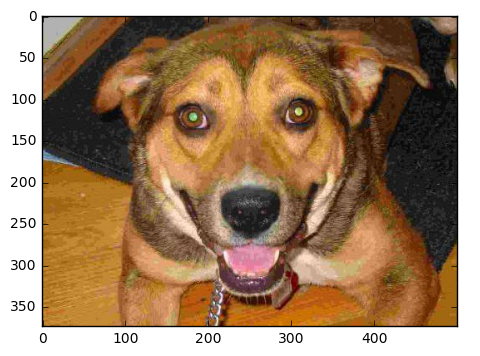

In [35]:
plt.imshow(img[0])

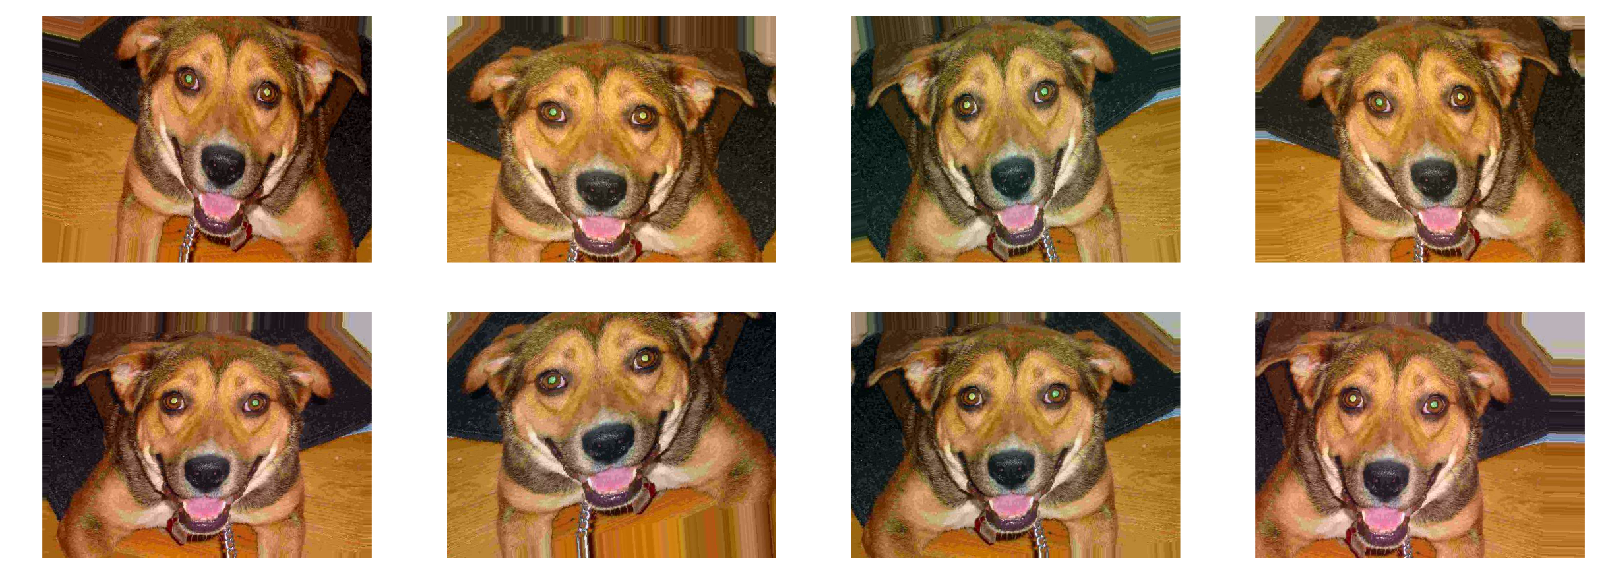

In [36]:
plots(aug_imgs, (20,7), 2)

In [37]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

## Let's augment our images

In [38]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [39]:
batches = get_batches(path+'train', gen, batch_size=batch_size)

Found 23000 images belonging to 2 classes.


** NB: We don't want to augment or shuffle the validation set **

In [40]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [41]:
fc_model = get_fc_model()

In [42]:
for layer in conv_model.layers: layer.trainable = False
# Connect the two models together
conv_model.add(fc_model)

In [43]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
23000/23000 [==============================] - 756s - loss: 0.3483 - acc: 0.9750 - val_loss: 0.2891 - val_acc: 0.9795
Epoch 2/8
 2240/23000 [=>............................] - ETA: 533s - loss: 0.3366 - acc: 0.9777

KeyboardInterrupt: 

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [45]:
conv_model.save_weights(model_path + 'aug1.h5')

In [ ]:
conv_model.load_weights(model_path + 'aug1.h5')

# Batchnorm

In [50]:
conv_layers[-1].output_shape

(None, 512, 14, 14)

In [47]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(1000, activation='softmax')
        ]

In [48]:
p =0.6

In [49]:
bn_model = Sequential(get_bn_layers(0.6))